# Trajectory Tracking with discrete actions in Reinforcement Learning

The following is an implementation of an environment that allows traejctory tracking for a given trajectory. <br />
The trajectory is defined as follows: <br />

$$
f(t) = \sin(t) + \cos(4 * t)
$$

The actions space is discretee and defined as following:

$$
\mathrm action = \begin{cases}
    0 & \text{direction is down} \\
    1 & \text{no direction} \\
    2 & \text{direction is up}
\end{cases}
$$

That is the agent needs to track trajectory only using the discrete actions. <br />
In order to do that, we define an margin (m), step (s), up and low boundaries ( $f^{up}$ and $f^{down}$ ) and agent value ( $A^{v}$ ): <br />

$$
m = 0.15 \\
s = 0.08 \\
\\
f^{up} = f(t) * (1 + m) \\
f^{down} = f(t) * (1 - m) \\
$$

$$
\mathrm A^{v}(t) = \begin{cases}
    A^{v}(t) + s * | f(t) - f^{up} | & \text{if direction is up} \\
    A^{v}(t) - s * | f(t) - f^{down} | & \text{if direction is down} \\
    A^{v}(t) & \text{no direction}
\end{cases}
$$

The purpose of the agent is to choose the right direction and keep $A^{v}$ into the boundaries. The following is an example:

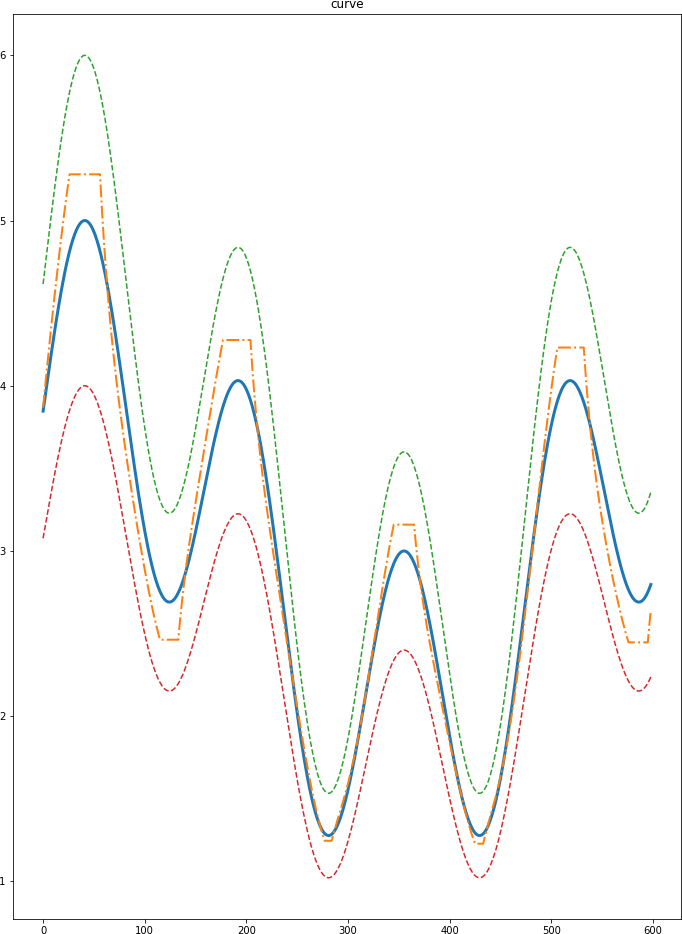

We also define a agent reward as follows:

$$
r(t) = 1 - | A^{v}(t) - f(t) | / ( m * f(t))
$$

We apply a cost every time the action changes it value. For direct transition from Up to Down and vie-versa the cost is double:

$$
cost(t) = - fee * | a(t) - a(t-1) |
$$

where a is the action.

In [1]:
import numpy as np
import pandas as pd
import random
from mpmath import mp, mpf
import math
import traceback
import sys
import os

### data factory

In [2]:
class DataSetSine:
    def __init__(self, config):
        self.episode = config.get('episode',600)
        self.is_training = config.get('is_training', True)
        self.is_testing = config.get('is_testing', False)
        self.normalizing = config.get('normalizing', False)
        self.normalize_window = config.get('normalize_window', 100)

        self.T = 1e6
        self.x = np.linspace(0, 1e4, int(self.T))
        self.data =  np.array([math.sin(i)+math.cos(4*i)+3. for i in self.x])

        self._init_dataset()

    def _init_dataset(self):
        self.dataset_len = self.data.shape[0]
        self.split_rate = .9
        train_set = int(math.ceil(self.data.shape[0] * self.split_rate))
        self.data_train = self.data[:train_set]
        self.data_test = self.data[train_set:]
        if self.is_training:
            self.data = self.data_train.copy()
        elif self.is_testing:
            self.data = self.data_test.copy()

    def set_testing(self):
        self.data = self.data_test.copy()
        self.is_training = False
        self.is_testing = True

    def set_training(self):
        self.data = self.data_train.copy()
        self.is_training = True
        self.is_testing = False

    def next(self):
        current_value = self.data[self.position]
        self.position += 1
        self.to_end -= 1
        # only executed if self.normalizing
        if self.normalizing:
            rolling_data = self.data[self.position-self.normalize_window-1:self.position].to_numpy()
            rolling_data_shifted = np.roll(rolling_data, 1, axis=0)
            norm_dataset = np.concatenate((rolling_data, rolling_data_shifted),axis=1)[1:,:]
            percentage_data = (norm_dataset[:,0]-norm_dataset[:,1])/norm_dataset[:,0]
            self.stddev = np.std(percentage_data)
            self.mean = np.mean(percentage_data)
            percentage_abs = np.array([np.abs(x) for x in percentage_data])
            self.mean_abs = np.mean(percentage_abs)

        if self.position >= self.end_tick or self.to_end <= 0:
            return .0, .0, True
        else:
            new_value = self.data[self.position]
            rew = (new_value - current_value)/current_value
            return rew, new_value, False

    def get_samples(self):
        c = self.data[self.position]
        c1 = self.data[self.position-1]
        c2 = self.data[self.position-2]
        c3 = self.data[self.position-3]
        return np.array(((c-c1)/c1,(c-c2)/c2,(c-c3)/c3))

    def get_current_value(self):
        return(self.data[self.position])

    def dataset_len(self):
        return(self.data.shape[0])

    def reset(self, position=None):
        cut_param = 50 + self.normalize_window

        if self.is_training:
            self.end_tick = self.data.shape[0] - self.episode - cut_param
            if position is not None:
                self.position = position
            else:
                self.position = self.start_tick = random.randint(cut_param, self.end_tick)
            self.to_end = self.episode
        else:
            self.position = self.start_tick = cut_param
            self.end_tick = self.data.shape[0] - cut_param
            self.to_end = self.end_tick - self.start_tick


### gym environment

In [1]:

import random
import json
import gym
from gym import spaces
from enum import Enum
from gym.utils import seeding

class FollowingActions(Enum):
    Down = 0
    Stay = 1
    Up = 2

class TrajectoryTrackingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, config={}):

        self.seed()

        self.episode = config.get("episode_len", 600)
        self.features = config.get("features", 3)
        self.stop_out_boundaries = config.get("stop_out_boundaries", False)
        self.normalizing = config.get("normalizing", False)
        self.bound_value = config.get("bound_value", 20e-2) # m
        self.step_value = config.get("step_value", 8e-2) # s
        self.fee = config.get("fee", 1.) # fee

        self.dataset = DataSetSine(config={'episode':self.episode})

        self.action_space = gym.spaces.Discrete(3)
        high=np.array([1.,1.,1.])
        self.observation_space=spaces.Box(-high, high)

        self.info = dict()
        self.infos = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def switch_to_train_dataset(self):
        self.dataset.set_training()

    def switch_to_test_dataset(self):
        self.dataset.set_testing()

    def reset(self, position=None):
        self.info = dict()
        self.infos = []
        self.dataset.reset(position)

        self.agent_value = self.dataset.get_current_value()
        self.target_value = self.dataset.get_current_value()
        self.up_bound = self.target_value * (1 + self.bound_value)
        self.lower_bound = self.target_value * (1 - self.bound_value)
        self.cost = 0.

        return self.dataset.get_samples()

    def step(self, action):
        completion_reward = 100.

        self.raw_reward, value, done = self.dataset.next()
        if done:
            if self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward+completion_reward, done, self.info
            else:
                return np.zeros(self.features), self.raw_reward, done, self.info

        self.target_value = self.dataset.get_current_value()
        self.up_bound = self.target_value * (1 + self.bound_value)
        self.lower_bound = self.target_value * (1 - self.bound_value)

        # only executed if self.stop_out_boundaries
        if self.agent_value > self.up_bound and self.stop_out_boundaries:
            self.agent_value = self.up_bound
            if self.dataset.is_training and self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward-completion_reward, True, self.info
        elif self.agent_value < self.lower_bound and self.stop_out_boundaries:
            self.agent_value = self.lower_bound
            if self.dataset.is_training and self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward-completion_reward, True, self.info

        if action == FollowingActions.Up.value:
            self.agent_value += self.step_value * np.abs(self.agent_value - self.up_bound)
        elif action == FollowingActions.Down.value:
            self.agent_value -= self.step_value * np.abs(self.agent_value - self.lower_bound)
            self.raw_reward = -self.raw_reward
        elif action == FollowingActions.Stay.value:
            self.raw_reward = .0

        self.agent_reward = 1. - np.abs(self.agent_value - value)/(self.bound_value * value)

        if "action" in self.info:
            self.cost = -self.fee * np.abs((action - 1) - (self.info["action"] - 1))
        else:
            self.cost = 0.

        self.total_reward = self.agent_reward + self.cost
        if self.normalizing:
            self.total_reward *= self.dataset.mean_abs / self.dataset.stddev

        obs = self.dataset.get_samples()
        f1 = obs[0]
        f2 = obs[1]
        f3 = obs[2]


        self.info = dict(
            value = value,
            agent_value = self.agent_value,
            up_bound = self.up_bound,
            lower_bound = self.lower_bound,
            raw_reward = self.raw_reward,
            agent_reward = self.agent_reward,
            total_reward = self.total_reward,
            cost = self.cost,
            action = action,
            f1 = f1,
            f2 = f2,
            f3 = f3
        )

        self.infos.append(self.info)

        return obs, self.total_reward, done, self.info

    def render(self, mode='human'):
        fig, axs = plt.subplots(3,4)
        fig.set_figheight(40)
        fig.set_figwidth(40)
        fig.suptitle('TrajectoryTracking')

        val = [d['value'] for d in self.infos]
        ag_val = [d['agent_value'] for d in self.infos]
        up_pr = [d['up_bound'] for d in self.infos]
        lower_pr = [d['lower_bound'] for d in self.infos]
        rew = [d['raw_reward'] for d in self.infos]
        agent_rew = [d['agent_reward'] for d in self.infos]
        cost = [d['cost'] for d in self.infos]
        tot_rew = [d['total_reward'] for d in self.infos]
        ac = [d['action'] for d in self.infos]
        f1 = [d['f1'] for d in self.infos]
        f2 = [d['f2'] for d in self.infos]
        f3 = [d['f3'] for d in self.infos]

        axs[0,0].plot(val, linewidth=3)
        axs[0,0].plot(ag_val, '-.', linewidth=2)
        axs[0,0].plot(up_pr, '--')
        axs[0,0].plot(lower_pr, '--')
        axs[0,0].set_title('curve')

        axs[0,1].plot(ac, color='green')
        axs[0,1].set_title('agent positions')

        axs[0,2].plot(rew)
        axs[0,2].set_title('raw rewards')

        N = 100
        axs[1,0].plot(f1[:N])
        axs[1,0].plot(f2[:N])
        axs[1,0].plot(f3[:N])
        axs[1,0].set_title('features')

        axs[1,1].plot(agent_rew)
        axs[1,1].set_title('agent rewards')

        axs[1,2].plot(tot_rew)
        axs[1,2].set_title('total rewards')

        axs[1,3].plot(cost)
        axs[1,3].set_title('total costs')

        agentrew = np.cumsum(agent_rew)
        axs[2,0].plot(agentrew)
        axs[2,0].set_title('cumulative agent rewards')

        totrew = np.cumsum(tot_rew)
        axs[2,1].plot(totrew)
        axs[2,1].set_title('cumulative total rewards')

        totrew = np.cumsum(rew)
        axs[2,2].plot(totrew)
        axs[2,2].set_title('cumulative raw rewards')

        axs[2,3].plot(np.cumsum(cost))
        axs[2,3].set_title('total costs')

        fig.tight_layout()

### get observations

In [7]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys

env = TrajectoryTrackingEnv()

observation = env.reset()

print(observation)

[0.00961533 0.01898079 0.02806503]


### data leak example

In the following example the agent knows thge value of the trajectory in advance and it tries to figure out what action to use on this basis. We basically have two simple policy, the first uses also the **stay** action while the second does not use. We can see the reward is bigger in the first case.

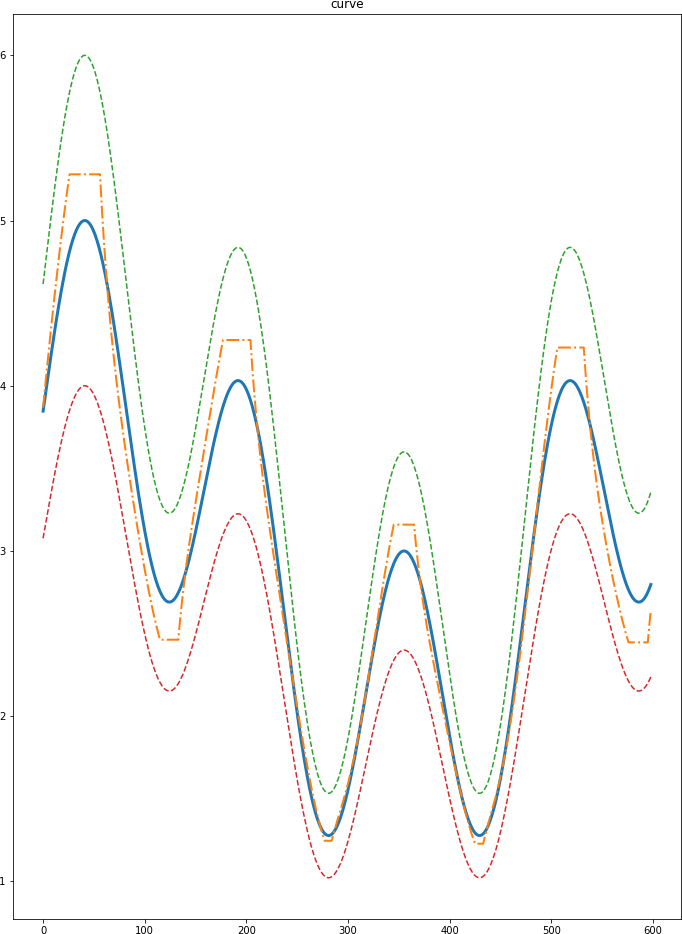

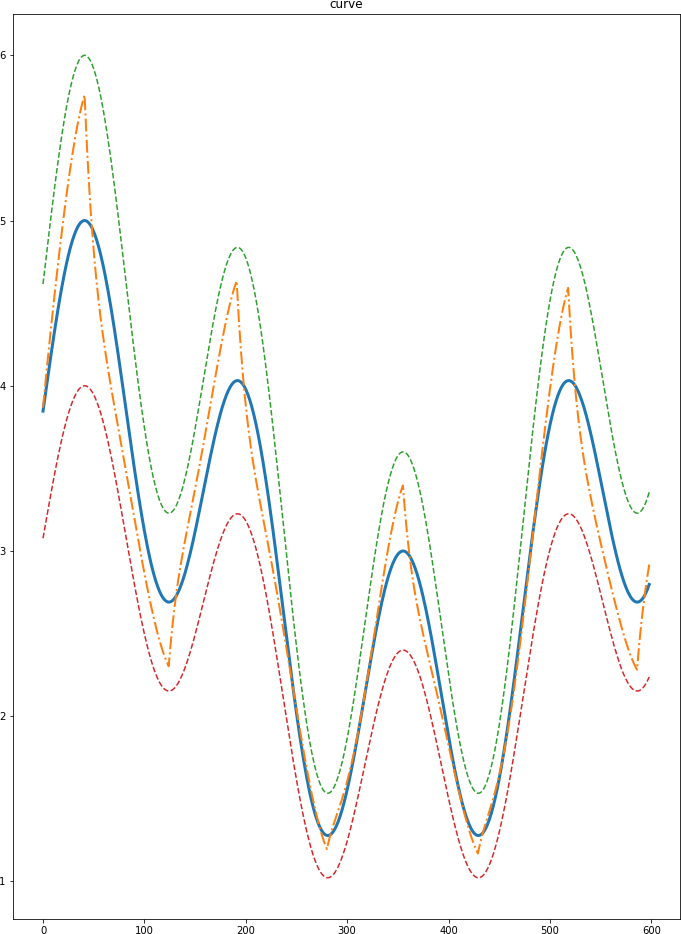


tested environment: #1, timesteps: 600, reward: 436.5314690189648
tested environment: #1, timesteps: 600, reward: 393.5003840585277


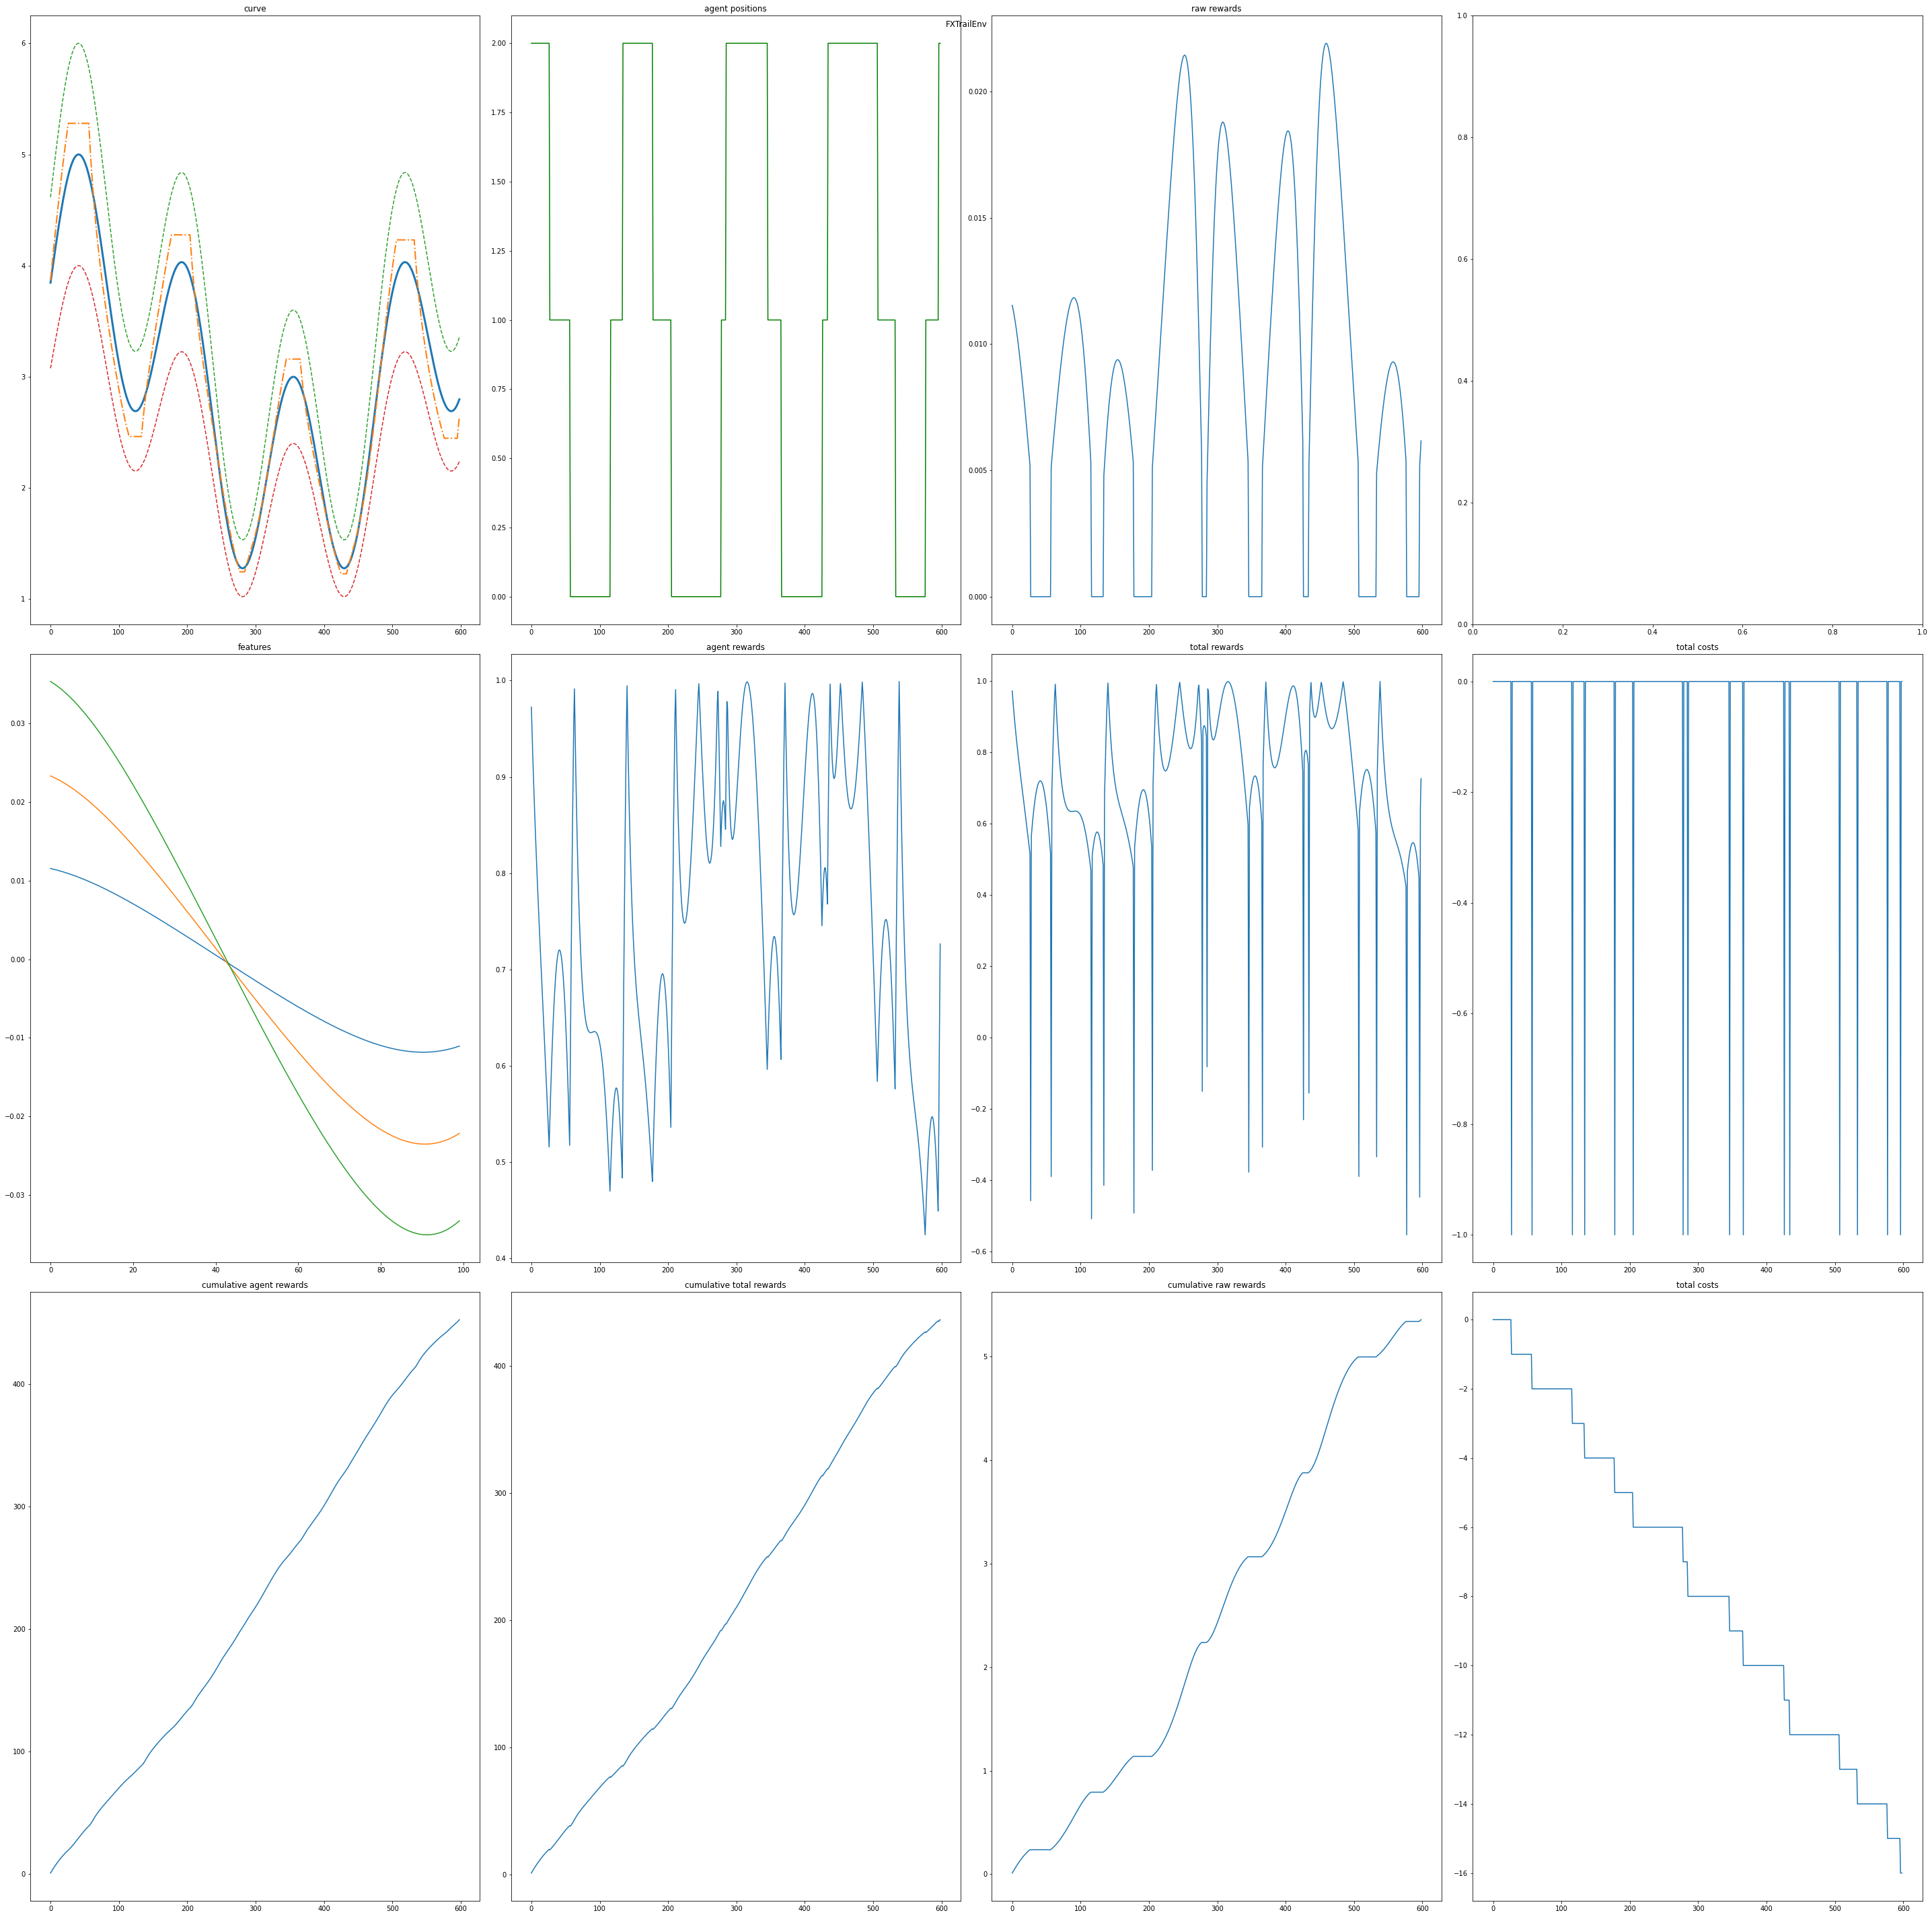

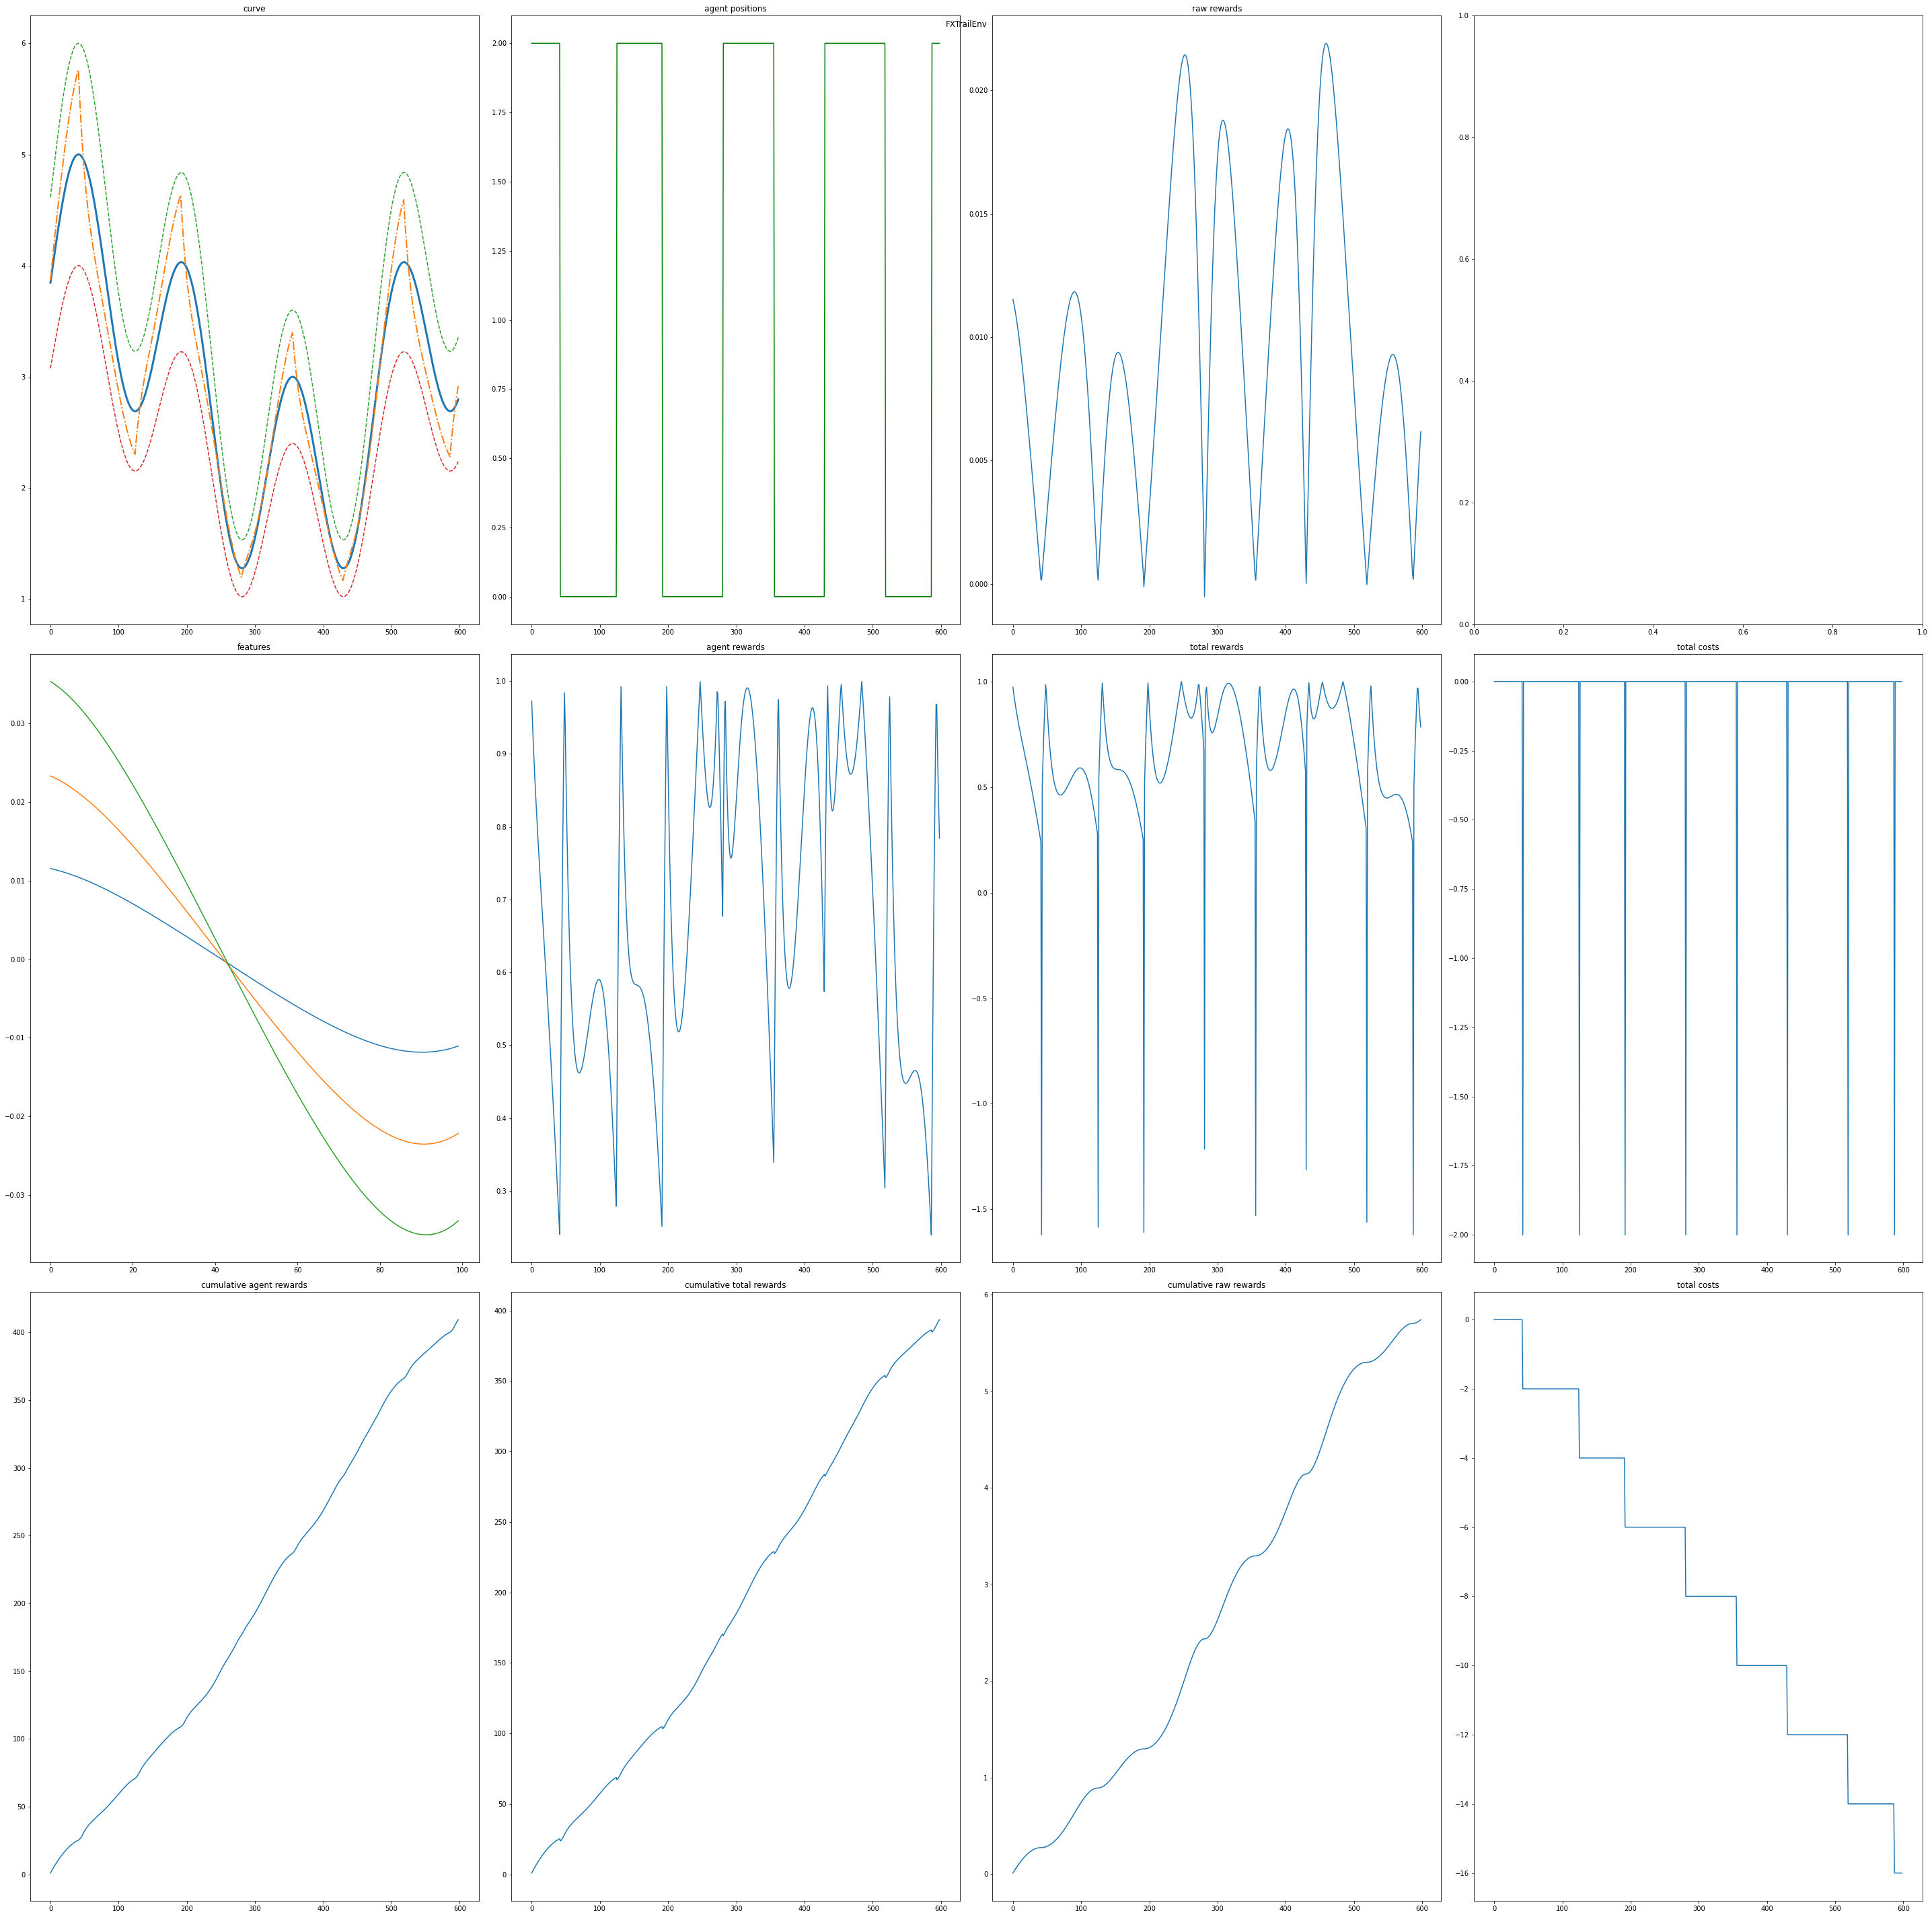

In [8]:
for k in range(1):
    observation = env.reset(position=2000)
    i = 0
    episode_reward = .0
    while True:
        trend = (env.dataset.data[env.dataset.position+2] - env.dataset.data[env.dataset.position])/env.dataset.data[env.dataset.position]
        if trend > 0.01:
            action = 2
        elif trend < -0.01:
            action = 0
        else:
            action = 1
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        i += 1
        if done:
            break
    print('tested environment: #{}, timesteps: {}, reward: {}'.format(k+1, i, episode_reward))
    env.render()
    observation = env.reset(position=2000)
    i = 0
    episode_reward = .0
    while True:
        trend = (env.dataset.data[env.dataset.position+2] - env.dataset.data[env.dataset.position])/env.dataset.data[env.dataset.position]
        if trend > .0:
            action = 2
        elif trend < -.0:
            action = 0
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        i += 1
        if done:
            break

    print('tested environment: #{}, timesteps: {}, reward: {}'.format(k+1, i, episode_reward))
    env.render()


### PPO configuration

In [14]:
import os
import numpy as np

import ray
from ray import tune
from ray.rllib.utils.test_utils import check_learning_achieved
from ray.rllib.agents.ppo import PPOTrainer

args = {'run': 'PPO',
        'framework': 'torch',
        'num_cpus': 0,
        'eager_tracing': False,
        'use_prev_action': True,
        'use_prev_reward': True,
        'stop_iters': 100,
        'stop_timesteps': 40e6,
        'stop_reward': 600.
       }


configs = {
    "PPO": {
        "num_sgd_iter": 5,
        "model": {
            "vf_share_layers": True,
        },
        "vf_loss_coeff": 1e-4,
    },
    "IMPALA": {
        "num_workers": 2,
        "num_gpus": 0,
        "vf_loss_coeff": 0.01,
    },
}

config = dict(
    configs[args['run']],
    **{
        "env": TrajectoryTrackingEnv,
        "num_gpus": 0,
        "model": {
            "use_lstm": True,
            "lstm_cell_size": 256,
            "lstm_use_prev_action": args['use_prev_action'],
            "lstm_use_prev_reward": args['use_prev_reward'],
        },
        "framework": args['framework'],
        # Run with tracing enabled for tfe/tf2?
        "eager_tracing": args['eager_tracing'],
    })

stop = {
    "training_iteration": args['stop_iters'],
    "timesteps_total": args['stop_timesteps'],
    "episode_reward_mean": args['stop_reward'],
}


### RLLIB training

In [ ]:
results = tune.run(args['run'], config=config, stop=stop, verbose=2, checkpoint_at_end=True)
    

### inference

In [ ]:
checkpoints = results.get_trial_checkpoints_paths(
    trial=results.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean")

checkpoint_path = checkpoints[0][0]
trainer = PPOTrainer(config)
trainer.restore(checkpoint_path)

# Inference loop.
env = TrajectoryTrackingEnv()
obs = env.reset()
# range(2) b/c h- and c-states of the LSTM.
lstm_cell_size = 256
init_state = state = [
        np.zeros([lstm_cell_size], np.float32) for _ in range(2)
]

# Run manual inference loop for n episodes.
for _ in range(10):
    episode_reward = 0.0
    reward = 0.0
    done = False
    obs = env.reset()
    state = init_state
    prev_a = 1
    prev_r = 0.0

    while not done:
        a, state_out, _ = trainer.compute_single_action(obs, state, prev_action=prev_a, prev_reward=prev_r)
        obs, reward, done, _ = env.step(a)
        episode_reward += reward
        prev_a = a
        prev_r = reward
        state = state_out

    print(f"Episode reward={episode_reward}")
    env.render()

ray.shutdown()
